In [1]:
import sys
sys.path.append('../..')
import pandas as pd
import backtrader as bt
from datetime import datetime
import matplotlib.pyplot as plt
from Tools.backtest_tools import *
import plotly.graph_objects as go
import numpy as np

ModuleNotFoundError: No module named 'Tools'

In [9]:
# Load the data and convert the timestamp to datetime
df = pd.read_csv('../../DB/15m/INJUSDT_15m.csv', parse_dates=True) 

# df['datetime'] = pd.to_datetime(df['datetime'], unit='ms')
# # # Convert 'date' to datetime format
df['datetime'] = pd.to_datetime(df['datetime'])  # Assuming the 'date' is in milliseconds

# # # Set 'date' as index
df.set_index('datetime', inplace=True)

# df.iloc[0]
# df.dtypes
# df.head()
df_t = df[:].copy()

In [10]:
class CobraStrategy:
    def __init__(
            self, 
            df, 
            type=['long', 'short'],
                                    ) -> None:
        
        self.df = df
        self.use_long = True if "long" in type else False
        self.use_short = True if "short" in type else False
        self.trades = pd.DataFrame()

    def smoothed(self, series, period=5):
        return series.rolling(window=period).mean()

    def populate_indicators(self):
        # -- Clear dataset --
        df = self.df
        df.drop(columns=df.columns.difference(['open','high','low','close','volume']), inplace=True)

        df["open_long_market"] = False
        df["close_long_market"] = False
        df["open_short_market"] = False
        df["close_short_market"] = False

        
        # -- Populate indicators --
        df['typical_price'] = (df['high'] + df['low'] + df['close']) / 3
        
        df['SMA_low_200'] = df['close'].rolling(window=200).mean()
        df['SMA_high_200'] = df['close'].rolling(window=200).mean()
        df['SMA_hlc_200'] = df['typical_price'].rolling(window=200).mean()

        df['SMA_low_10'] = df['close'].rolling(window=40).mean()
        df['SMA_high_10'] = df['close'].rolling(window=40).mean()
        df['SMA_hlc_10'] = df['typical_price'].rolling(window=40).mean()

        df['previous_close'] = df['close'].shift(1)
        df['TR'] = np.maximum(df['high'] - df['low'], 
                      np.maximum(abs(df['high'] - df['previous_close']), abs(df['low'] - df['previous_close'])))

        # Calculate Positive and Negative Directional Movement (DM+ and DM-)
        df['DM+'] = np.where((df['high'] - df['high'].shift(1)) > (df['low'].shift(1) - df['low']), 
                            np.maximum(df['high'] - df['high'].shift(1), 0), 0)
        df['DM-'] = np.where((df['low'].shift(1) - df['low']) > (df['high'] - df['high'].shift(1)), 
                            np.maximum(df['low'].shift(1) - df['low'], 0), 0)
        

        df['TR_smooth'] = self.smoothed(df['TR'], 10)
        df['DM+_smooth'] = self.smoothed(df['DM+'], 10)
        df['DM-_smooth'] = self.smoothed(df['DM-'], 10)

        # Calculate DI+
        df['DI+'] = 100 * (df['DM+_smooth'] / df['TR_smooth'])

        # Calculate DI-
        df['DI-'] = 100 * (df['DM-_smooth'] / df['TR_smooth'])

        # Calculate the Directional Index (DX)
        df['DX'] = 100 * (abs(df['DI+'] - df['DI-']) / (df['DI+'] + df['DI-']))

        # Calculate ADX by smoothing DX over 5 periods
        df['ADX'] = self.smoothed(df['DX'], 10)
        
        self.df = df    
        return self.df

    def populate_buy_sell(self): 
        df = self.df
        # -- Initiate populate --
        if self.use_long:
            # -- Populate open long market --
            df.loc[
                (df['close'] > df['SMA_hlc_200']) 
                & (df['SMA_high_10'] > df['SMA_hlc_200']) 
                & (df['close'] > df['SMA_high_10']) 
                & (df['ADX'] > 40) 

                , "open_long_market"
            ] = True
            
            # -- Populate close long market --
            df.loc[
                (df['close'] < df['SMA_low_10']) 
                & (df['ADX'] > 75) 
                , "close_long_market"
            ] = True

        if self.use_short:
            # -- Populate open short market --
            df.loc[
                (df['close'] < df['SMA_hlc_200']) 
                & (df['SMA_high_10'] < df['SMA_hlc_200']) 
                & (df['close'] < df['SMA_high_10']) 
                & (df['ADX'] > 40) 
                
                , "open_short_market"
            ] = True
            
            # -- Populate close short market --
            df.loc[
                (df['close'] > df['SMA_low_10'])
                & (df['ADX'] > 75)
                , "close_short_market"
            ] = True
               
        self.df = df   
        return self.df

    # Running the backtest
    
    def run_backtest(self, initial_wallet=1000, leverage=1):
        df = self.df[:]
        wallet = initial_wallet
        maker_fee = 0.0002
        taker_fee = 0.0007
        trades = []
        days = []
        current_day = 0
        previous_day = 0
        current_position = None

        for index, row in df.iterrows():
            
            # -- Add daily report --
            current_day = index.day
            if previous_day != current_day:
                temp_wallet = wallet
                if current_position:
                    if current_position['side'] == "LONG":
                        close_price = row['close']
                        trade_result = (close_price - current_position['price']) / current_position['price']
                        temp_wallet += temp_wallet * trade_result
                        fee = temp_wallet * taker_fee
                        temp_wallet -= fee
                    elif current_position['side'] == "SHORT":
                        close_price = row['close']
                        trade_result = (current_position['price'] - close_price) / current_position['price']
                        temp_wallet += temp_wallet * trade_result
                        fee = temp_wallet * taker_fee
                        temp_wallet -= fee
                    
                days.append({
                    "day":str(index.year)+"-"+str(index.month)+"-"+str(index.day),
                    "wallet":temp_wallet,
                    "price":row['close']
                })
            previous_day = current_day
            if current_position:
            # -- Check for closing position --
                if current_position['side'] == "LONG":                     
                    # -- Close LONG market --
                    if row['close_long_market']:
                        close_price = row['close']
                        trade_result = ((close_price - current_position['price']) / current_position['price']) * leverage
                        wallet += wallet * trade_result
                        fee = wallet * taker_fee
                        wallet -= fee
                        trades.append({
                            "open_date": current_position['date'],
                            "close_date": index,
                            "position": "LONG",
                            "open_reason": current_position['reason'],
                            "close_reason": "Market",
                            "open_price": current_position['price'],
                            "close_price": close_price,
                            "open_fee": current_position['fee'],
                            "close_fee": fee,
                            "open_trade_size":current_position['size'],
                            "close_trade_size": wallet,
                            "wallet": wallet
                        })
                        current_position = None
                        
                elif current_position['side'] == "SHORT":
                    # -- Close SHORT Market --
                    if row['close_short_market']:
                        close_price = row['close']
                        trade_result = ((current_position['price'] - close_price) / current_position['price']) * leverage
                        wallet += wallet * trade_result
                        fee = wallet * taker_fee
                        wallet -= fee
                        trades.append({
                            "open_date": current_position['date'],
                            "close_date": index,
                            "position": "SHORT",
                            "open_reason": current_position['reason'],
                            "close_reason": "Market",
                            "open_price": current_position['price'],
                            "close_price": close_price,
                            "open_fee": current_position['fee'],
                            "close_fee": fee,
                            "open_trade_size": current_position['size'],
                            "close_trade_size": wallet,
                            "wallet": wallet
                        })
                        current_position = None

            # -- Check for opening position --
            else:
                # -- Open long Market --
                if row['open_long_market']:
                    open_price = row['close']
                    fee = wallet * taker_fee
                    wallet -= fee
                    pos_size = wallet
                    current_position = {
                        "size": pos_size,
                        "date": index,
                        "price": open_price,
                        "fee":fee,
                        "reason": "Market",
                        "side": "LONG",
                    }
                elif row['open_short_market']:
                    open_price = row['close']
                    fee = wallet * taker_fee
                    wallet -= fee
                    pos_size = wallet
                    current_position = {
                        "size": pos_size,
                        "date": index,
                        "price": open_price,
                        "fee":fee,
                        "reason": "Market",
                        "side": "SHORT"
                    }
                    
                    
        df_days = pd.DataFrame(days)
        df_days['day'] = pd.to_datetime(df_days['day'])
        df_days = df_days.set_index(df_days['day'])

        df_trades = pd.DataFrame(trades)
        if df_trades.empty:
            print("!!! No trades")
            return None
        else:
            df_trades['open_date'] = pd.to_datetime(df_trades['open_date'])
            df_trades = df_trades.set_index(df_trades['open_date'])  
            self.trades = df_trades
        
        return get_metrics(df_trades, df_days) | {
            "wallet": wallet,
            "trades": df_trades,
            "days": df_days
        }       
        

    def plot(self, fr, to):
        plot_df = self.df[fr:to].copy()

        # Create two subplots (one for the price and one for the ADX)
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 14), sharex=True)

        # Plot the price and SMAs on the first axis (ax1)
        ax1.plot(plot_df['close'], label='Close Price')
        ax1.plot(plot_df['SMA_low_200'], label='l200')
        ax1.plot(plot_df['SMA_high_200'], label='h200')
        ax1.plot(plot_df['SMA_hlc_200'], label='hlc200')
        ax1.plot(plot_df['SMA_low_10'], label='l10')
        ax1.plot(plot_df['SMA_high_10'], label='h10')
        ax1.plot(plot_df['SMA_hlc_10'], label='hlc10')
        # Adjust scatter points to be close to the price line
        scatter_long_open_y = plot_df['open_long_market'] == True
        scatter_long_close_y = plot_df['close_long_market'] == True
        scatter_short_open_y = plot_df['open_short_market'] == True
        scatter_short_close_y = plot_df['close_short_market'] == True

        # Optionally, add a small offset to the scatter points to make them visually distinct
        offset = plot_df['close']  # 2% of price range

        ax1.scatter(plot_df.index, scatter_long_open_y+offset , label='Open Long', color='green', marker='^', s=100)  # Up triangle for open
        ax1.scatter(plot_df.index, scatter_long_close_y +offset, label='Close Long', color='red', marker='v', s=100)  # Down triangle for close
        ax1.scatter(plot_df.index, scatter_short_open_y+offset , label='Open Short', color='blue', marker='v', s=100)  # Up triangle for open
        ax1.scatter(plot_df.index, scatter_short_close_y +offset, label='Close Short', color='orange', marker='^', s=100)  # Down triangle for close

        # Adjust y-axis limits to zoom into the price fluctuations
        close_min = plot_df['close'].min()
        close_max = plot_df['close'].max()
        y_margin = (close_max - close_min) * 0.05  # Add 5% margin to y-axis limits
        ax1.set_ylim(close_min - y_margin, close_max + y_margin)

        ax1.set_title('Price and SMAs')
        ax1.legend()


        # Plot the ADX on the second axis (ax2)
        ax2.plot(plot_df['ADX'], label='ADX', color='orange')
        ax2.axhline(75, color='red', linestyle='--', label='ADX 75 Threshold')
        ax2.axhline(40, color='red', linestyle='--', label='ADX 40 Threshold')
        ax2.set_title('ADX')
        ax2.legend()

        plt.tight_layout()

        # Show the plot
        plt.show()
            

        # # Création du graphique
        # fig = go.Figure()

        # # Ajouter les bougies
        # fig.add_trace(go.Candlestick(
        #     x=df.index,
        #     open=df['open'],
        #     high=df['high'],
        #     low=df['low'],
        #     close=df['close'],
        #     name='Candlestick',
        #     line=dict(width=1), opacity=1
        # ))

        # # Ajouter le Parabolic SAR
        # fig.add_trace(go.Scatter(
        #     x=df.index,
        #     y=df['SAR'],
        #     mode='lines',
        #     name='Parabolic SAR',
        #     line=dict(color='orange')
        # ))

        # # Ajouter les signaux d'achat et de vente
        # fig.add_trace(go.Scatter(
        #     x=df.index[df['signal'] == 1],
        #     y=df['close'][df['signal'] == 1],
        #     mode='markers',
        #     marker=dict(color='green', symbol='triangle-up', size=10),
        #     name='Buy Signal'
        # ))

        # fig.add_trace(go.Scatter(
        #     x=df.index[df['signal'] == -1],
        #     y=df['close'][df['signal'] == -1],
        #     mode='markers',
        #     marker=dict(color='red', symbol='triangle-down', size=10),
        #     name='Sell Signal'
        # ))

        # # Mettre en forme le graphique
        # fig.update_layout(
        #     title='Parabolic SAR Strategy',
        #     xaxis_title='Date',
        #     yaxis_title='Price',
        #     xaxis_rangeslider_visible=False,
        #     height=600
        # )

        # Afficher le graphique
        # return fig.show()

In [11]:
strat = CobraStrategy(df_t)
strat.populate_indicators()
strat.populate_buy_sell()

,open,high,low,close,volume,open_long_market,close_long_market,open_short_market,close_short_market,typical_price,...,TR,DM+,DM-,TR_smooth,DM+_smooth,DM-_smooth,DI+,DI-,DX,ADX
datetime,,,,,,,,,,,,,,,,,,,,,
2022-11-21 03:15:00,1.564,1.564,1.553,1.563,0,False,False,False,False,1.560000,...,NaN,0.000,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-11-21 03:30:00,1.563,1.579,1.563,1.577,0,False,False,False,False,1.573000,...,0.016,0.015,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-11-21 03:45:00,1.577,1.583,1.576,1.581,0,False,False,False,False,1.580000,...,0.007,0.004,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-11-21 04:00:00,1.581,1.585,1.577,1.584,0,False,False,False,False,1.582000,...,0.008,0.002,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-11-21 04:15:00,1.584,1.593,1.584,1.587,0,False,False,False,False,1.588000,...,0.009,0.008,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-03 10:30:00,16.790,16.810,16.703,16.720,0,False,False,False,False,16.744333,...,0.107,0.015,0.000,0.1224,0.0158,0.0312,12.908497,25.490196,32.765957,58.984897
2024-09-03 10:45:00,16.720,16.748,16.648,16.748,0,False,False,False,False,16.714667,...,0.100,0.000,0.055,0.1139,0.0158,0.0263,13.871817,23.090430,24.940618,55.579378
2024-09-03 11:00:00,16.748,16.794,16.708,16.771,0,False,False,False,False,16.757667,...,0.086,0.046,0.000,0.1044,0.0204,0.0123,19.540230,11.781609,24.770642,51.556442


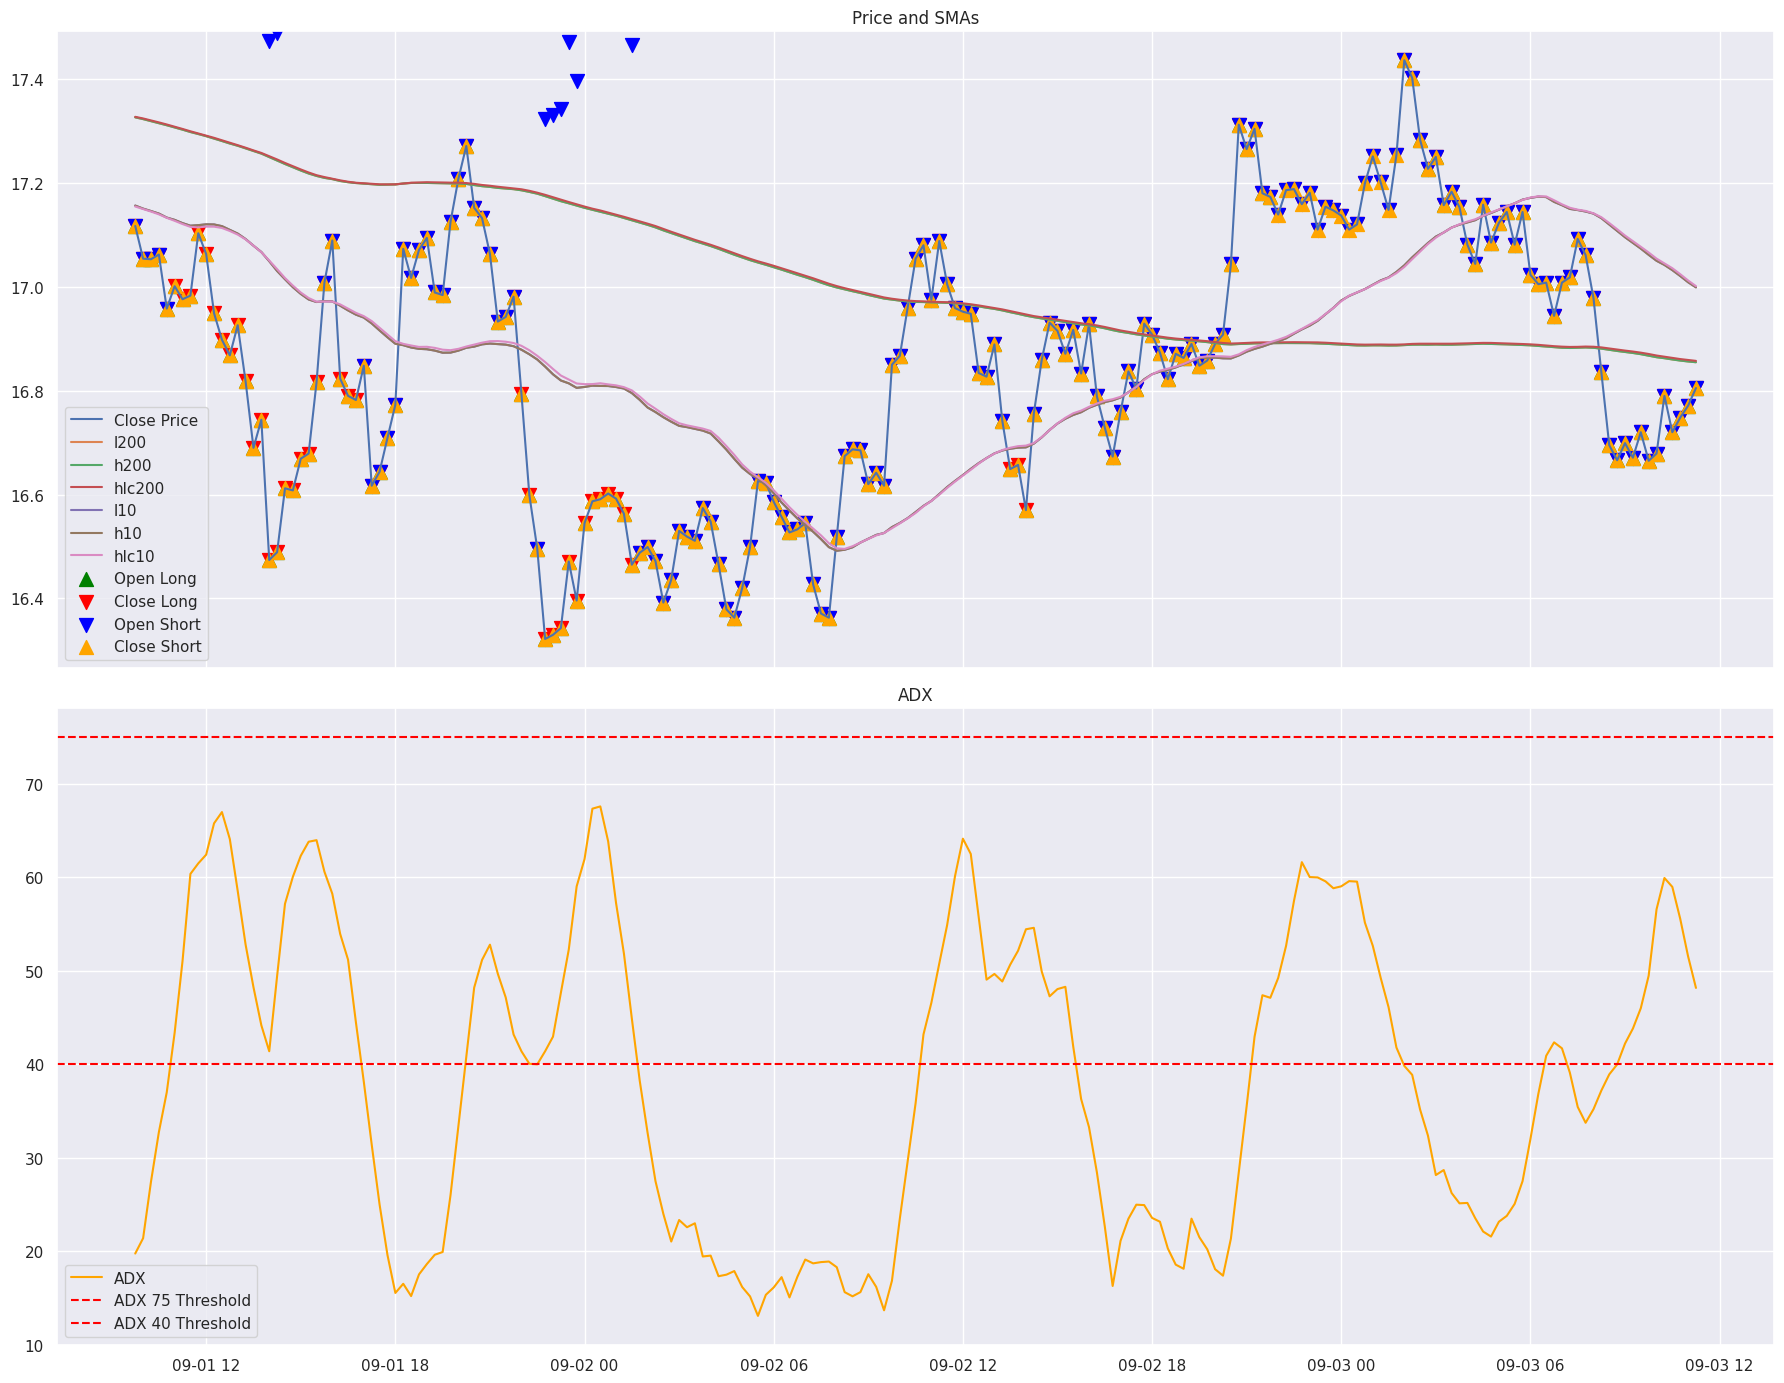

Period: [2022-11-21 00:00:00] -> [2024-09-03 00:00:00]
Initial wallet: 1000.0 $

--- General Information ---
Final wallet: 561.98 $
Performance vs US dollar: -43.8 %
Sharpe Ratio: 0.24
Worst Drawdown T|D: -94.39% | -94.73%
Buy and hold performance: 996.42 %
Performance vs buy and hold: -94.87 %
Total trades on the period: 243
Global Win rate: 34.98 %
Average Profit: 0.25 %
Total fees paid 612.06$

Best trades: +75.1 % the 2023-12-06 01:45:00 -> 2023-12-15 09:00:00
Worst trades: -26.41 % the 2023-01-24 23:45:00 -> 2023-01-25 14:30:00


,open_date,close_date,position,open_reason,close_reason,open_price,close_price,open_fee,close_fee,open_trade_size,close_trade_size,wallet,trade_result,trade_result_pct,trade_result_pct_wallet,wallet_ath,drawdown,drawdown_pct
open_date,,,,,,,,,,,,,,,,,,
2022-11-23 05:00:00,2022-11-23 05:00:00,2022-11-24 11:30:00,LONG,Market,Market,1.675,1.646,0.700000,0.687399,999.300000,981.311287,981.311287,-18.688713,-0.018702,-0.019414,981.311287,0.000000,0.000000
2022-11-25 00:15:00,2022-11-25 00:15:00,2022-11-25 20:30:00,SHORT,Market,Market,1.640,1.611,0.686918,0.698575,980.624370,997.266103,997.266103,15.954816,0.016270,0.015747,997.266103,0.000000,0.000000
2022-11-26 11:45:00,2022-11-26 11:45:00,2022-11-26 20:00:00,LONG,Market,Market,1.634,1.611,0.698086,0.687778,996.568017,981.852660,981.852660,-15.413444,-0.015467,-0.015949,997.266103,15.413444,0.015456
2022-11-27 02:00:00,2022-11-27 02:00:00,2022-11-28 22:45:00,SHORT,Market,Market,1.604,1.523,0.687297,0.721499,981.165363,1029.991491,1029.991491,48.138831,0.049063,0.044650,1029.991491,0.000000,0.000000
2022-11-29 00:00:00,2022-11-29 00:00:00,2022-11-29 04:15:00,SHORT,Market,Market,1.513,1.589,0.720994,0.684298,1029.270497,976.884574,976.884574,-53.106917,-0.051597,-0.057489,1029.991491,53.106917,0.051561
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-16 11:00:00,2024-08-16 11:00:00,2024-08-17 10:45:00,SHORT,Market,Market,18.260,18.061,0.369227,0.372990,527.097893,532.469289,532.469289,5.002169,0.009490,0.009307,5895.540510,5363.071221,0.909683
2024-08-17 21:00:00,2024-08-17 21:00:00,2024-08-24 23:00:00,LONG,Market,Market,18.375,22.040,0.372729,0.446758,532.096560,637.779537,637.779537,105.310249,0.197916,0.141719,5895.540510,5257.760973,0.891820
2024-08-25 08:30:00,2024-08-25 08:30:00,2024-08-25 15:15:00,SHORT,Market,Market,21.183,22.030,0.446446,0.428295,637.333092,611.421101,611.421101,-26.358436,-0.041357,-0.045052,5895.540510,5284.119409,0.896291


In [12]:

strat.plot(-200,-1)
# strat.trades
bt_result = strat.run_backtest(initial_wallet=1000, leverage=1)
df_trades, df_days = basic_single_asset_backtest(trades=bt_result['trades'], days=bt_result['days'])
df_trades


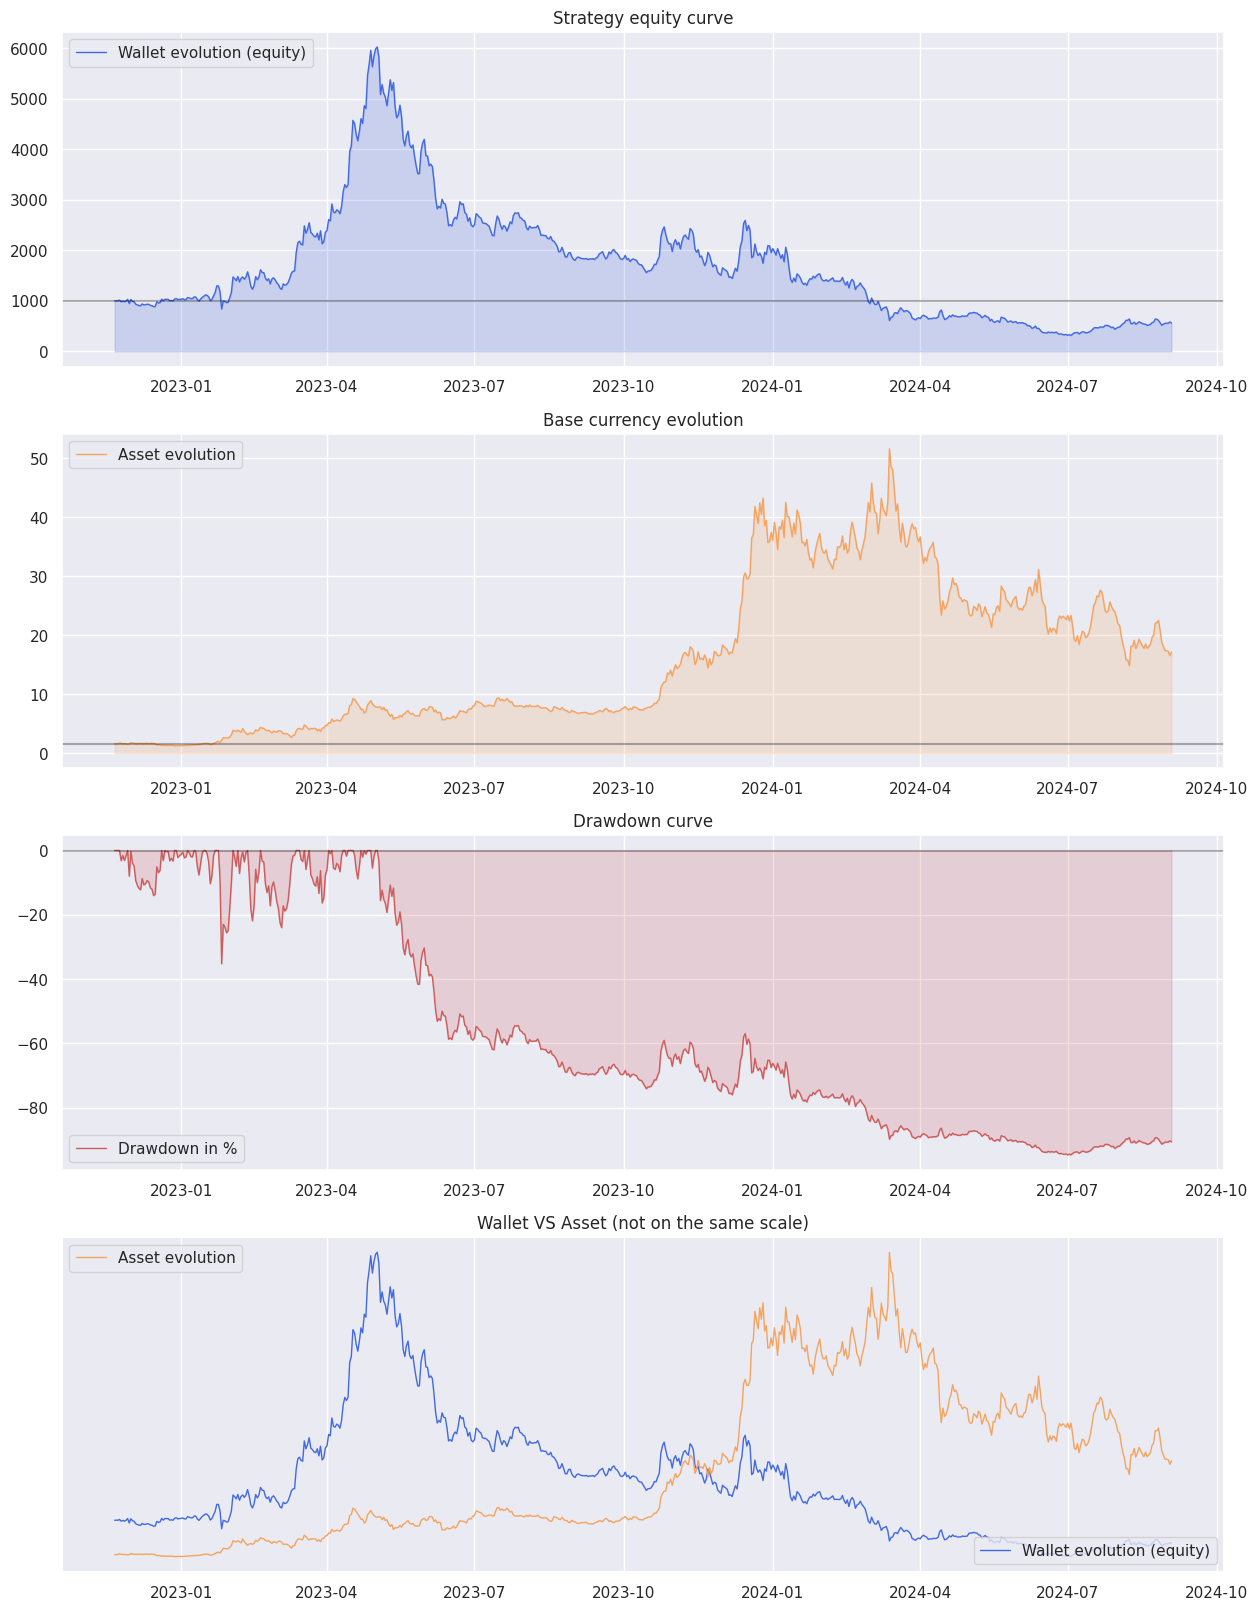

In [13]:
plot_wallet_vs_asset(df_days=df_days)

In [14]:
plot_futur_simulations(
    df_trades=df_trades,
    trades_multiplier=1,
    trades_to_forecast=1000,
    number_of_simulations=100,
    true_trades_to_show=10,
    show_all_simulations=True,
)

ValueError: Sample larger than population or is negative

----- 2022 Cumulative Performances: -27.84% -----


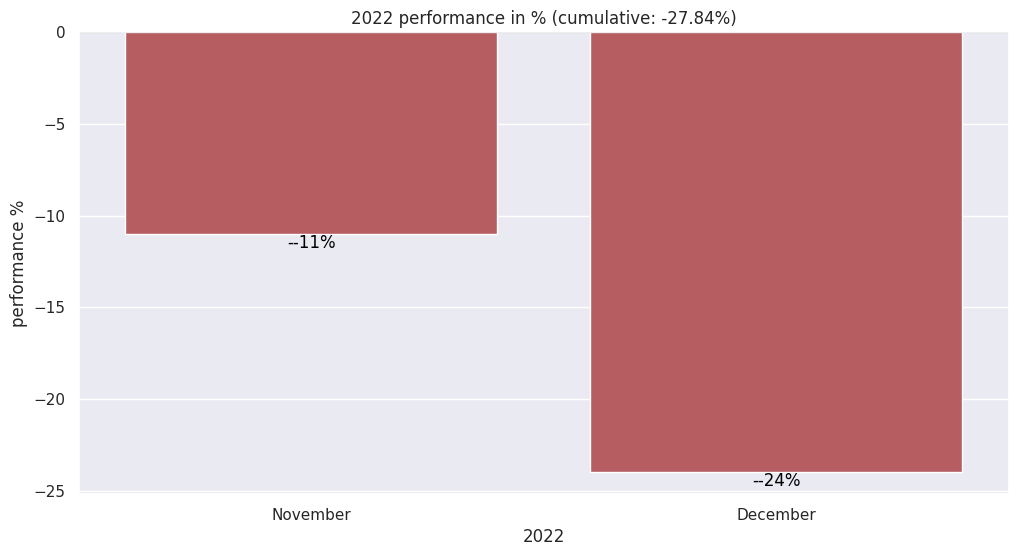

----- 2023 Cumulative Performances: -80.82% -----


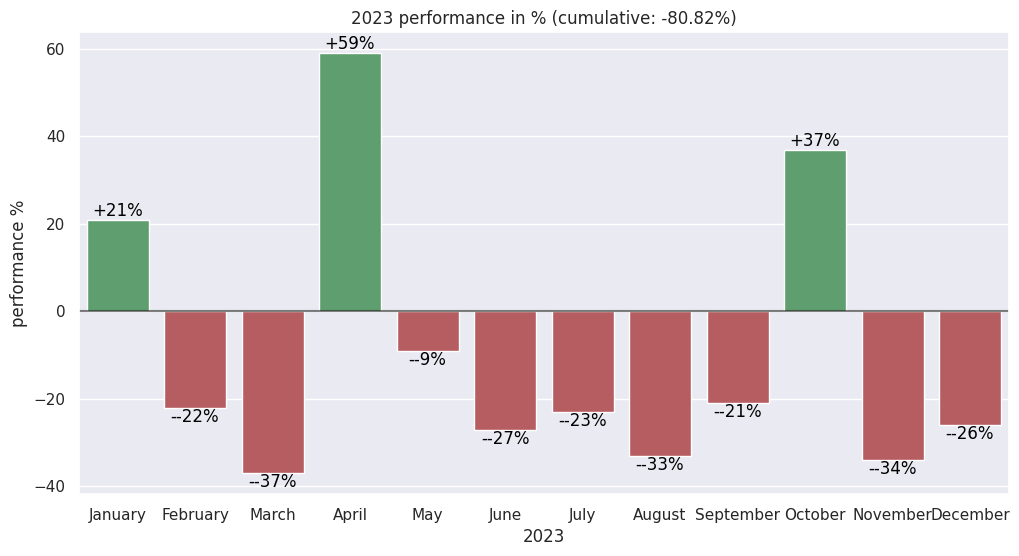

----- 2024 Cumulative Performances: -69.78% -----


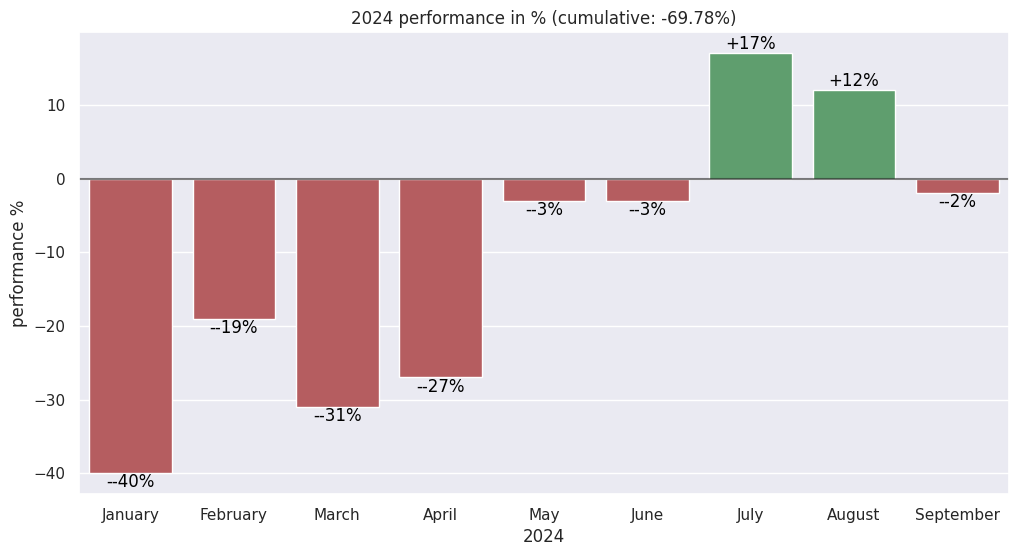

In [30]:
plot_bar_by_month(df_days=df_days)